# Simple activations
In this notebook we will analyze the activations of a neural network after it is trained on a simple dataset.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy

import umap
from openTSNE import TSNE

from src.dataset import Dataset

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Data

Load simple dataset.

In [3]:
simple_ds = Dataset("simple", device)
x = simple_ds.data
y = simple_ds.labels

x_np = x.to("cpu").numpy()
y_np = y.to("cpu").numpy()

### Model

The model we are going to train.

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_in, n_out):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(n_in, 20)
        self.l2 = nn.Linear(20, 15)
        self.l3 = nn.Linear(15, 10)
        self.out = nn.Linear(10, n_out)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.out(x))
        return x
    
    def activations(self, x):
        activations = []
        activations.append(x.detach().to("cpu").numpy())
        
        x = F.relu(self.l1(x))
        activations.append(x.detach().to("cpu").numpy())
        
        x = F.relu(self.l2(x))
        activations.append(x.detach().to("cpu").numpy())
        
        x = F.relu(self.l3(x))
        activations.append(x.detach().to("cpu").numpy())
        
        x = F.relu(self.out(x))
        
        return activations

In [5]:
network = NeuralNetwork(25, 3)
network.to(device)

NeuralNetwork(
  (l1): Linear(in_features=25, out_features=20, bias=True)
  (l2): Linear(in_features=20, out_features=15, bias=True)
  (l3): Linear(in_features=15, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=3, bias=True)
)

### Training

These training procedures aren't well suited for bigger datasets, but they suffice for the `simple` dataset.

In [6]:
def train(data, labels, model, loss_fn, optimizer):
    pred = model(data)
    loss = loss_fn(pred, labels)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [7]:
def training_loop(epochs, data, labels, model, loss_fn, optimizer, batch_size=9):
    losses = []
    
    for t in range(epochs):
        indices = random.sample(range(9), batch_size)
        batch_x = data[indices]
        batch_y = labels[indices]
        
        loss = train(batch_x, batch_y, model, loss_fn, optimizer)
        if (t % (epochs // 5) == 0):
            print("Epoch " + str(t))
            print("Loss " + str(loss))
            
        if (t % (epochs // 100) == 0):
            losses.append(loss)
    
    plt.plot(losses)

In [8]:
def training_loop_multiple(epochs, data, labels, model, loss_fn, optimizer, batch_size=9):
    last_loss = 0
    
    for t in range(epochs):
        indices = random.sample(range(9), batch_size)
        batch_x = data[indices]
        batch_y = labels[indices]
        
        loss = train(batch_x, batch_y, model, loss_fn, optimizer)
        last_loss = loss
    
    return loss

### Visualizations

We will be looking at activations in a network. We pass each example to the network, note the activations, split them by layers and train a t-SNE / UMAP model on the whole dataset.

In [9]:
def activations_tsne_plot(activations, labels, ds):
    tsne = TSNE(
        perplexity=2,
        metric="euclidean",
        n_jobs=8,
        random_state=42,
        verbose=False,
    )
    fig, axes = plt.subplots(nrows=1, ncols=len(activations), figsize=(25,5))

    for idx, acts in enumerate(activations):
        embeddings = tsne.fit(acts)

        for c in range(ds.n_classes):
            indices = np.argwhere(labels == c)
            indices = np.squeeze(indices)

            actual_label = ds.index_to_class[c]

            axes[idx].scatter(embeddings[indices,0],embeddings[indices,1],label=actual_label)
            axes[idx].legend()
            axes[idx].set_title("Activations in layer " + str(idx))

    fig.tight_layout()

In [10]:
def activations_umap_plot(activations, labels, ds):
    reducer = umap.UMAP()
    fig, axes = plt.subplots(nrows=1, ncols=len(activations), figsize=(25,5))

    for idx, acts in enumerate(activations):
        embeddings = reducer.fit_transform(acts)

        for c in range(ds.n_classes):
            indices = np.argwhere(labels == c)
            indices = np.squeeze(indices)

            actual_label = ds.index_to_class[c]

            axes[idx].scatter(embeddings[indices,0],embeddings[indices,1],label=actual_label)
            axes[idx].legend()
            axes[idx].set_title("Activations in layer " + str(idx))

    fig.tight_layout()

Based on the initialization the network converges to various minima, some of them clearly better than others. We will thus perform several runs and choose the best of them. We will always remember both the trained network and its untrained counterpart; this will allow us to compare activations in each.

In [11]:
best_network = None
best_untrained = None
best_loss = None

trials = 10
for trial in range(trials):
    print("Trial", trial + 1)
    
    network = NeuralNetwork(25, 3)
    network.to(device)
    untrained_state = deepcopy(network.state_dict())
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(network.parameters(), lr=0.1)

    epochs = 1000
    loss = training_loop_multiple(epochs, x, y, network, loss_fn, optimizer)
    
    if best_network is None:
        best_network = network
        best_untrained = NeuralNetwork(25, 3)
        best_untrained.to(device).load_state_dict(untrained_state)
        best_loss = loss
    elif loss < best_loss:
        best_network = network
        best_untrained = NeuralNetwork(25, 3)
        best_untrained.to(device).load_state_dict(untrained_state)
        best_loss = loss
        
best_loss

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10


0.0004755610425490886

#### t-SNE

Activations in the untrained network reduced to 2D using t-SNE. We can see that t-SNE wasn't able to cluster same examples together.

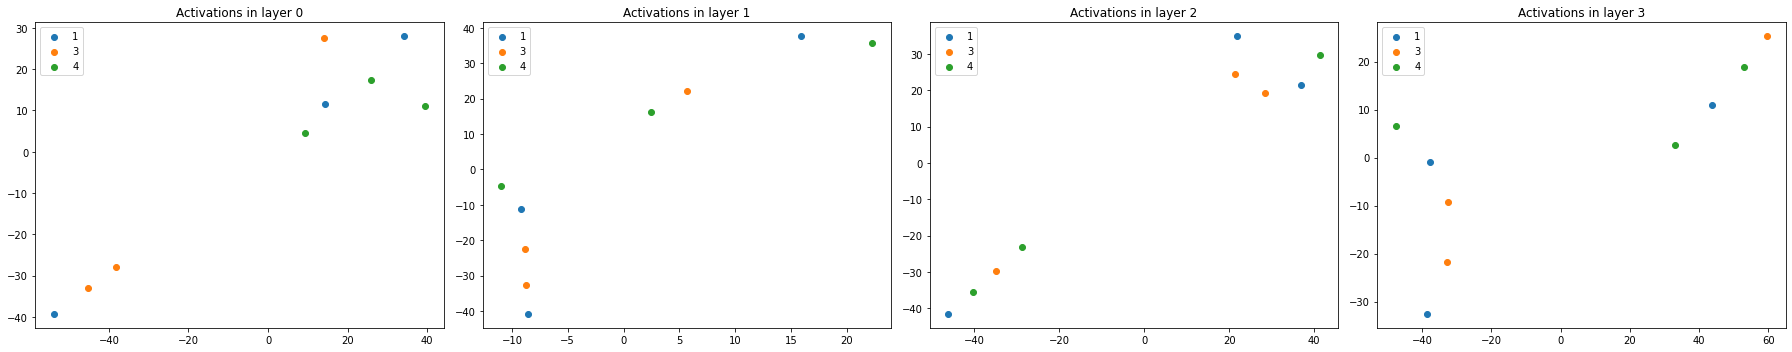

In [12]:
activations = best_untrained.activations(x)
activations_tsne_plot(activations, y_np, simple_ds)

Activations in the trained network. Here we can see that not only t-SNE is able to cluster same examples together, but it is able to do so in the very first layer of the network. This suggests that our choice of network architecture wasn't perhaps the best, as one layer was able to capture enough information to allow t-SNE to properly cluster the data. We might consider reducing the depth of the network to a single layer, as that would probably suffice.

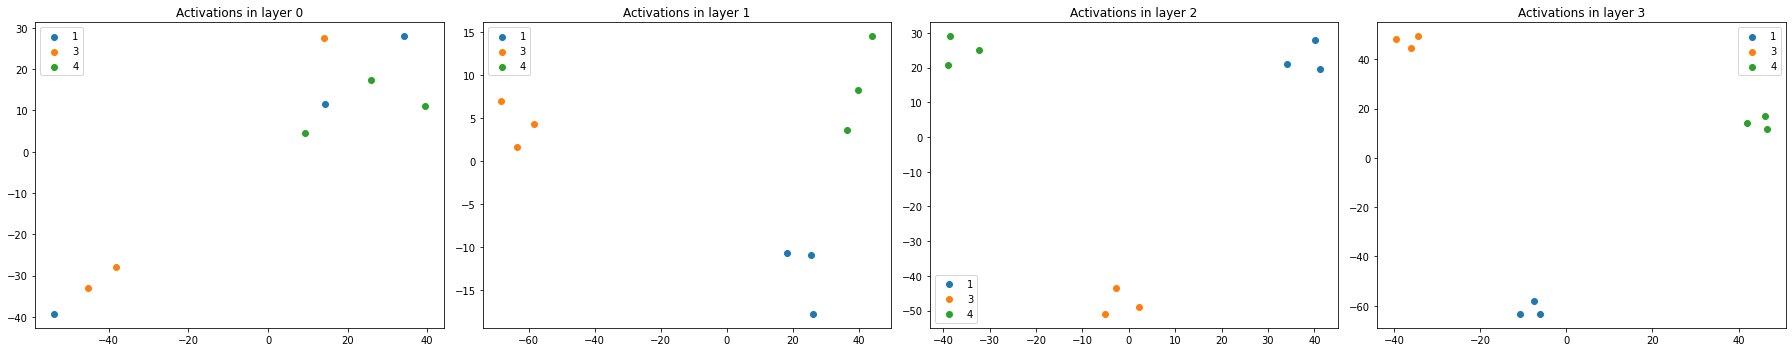

In [13]:
activations = best_network.activations(x)
activations_tsne_plot(activations, y_np, simple_ds)

#### UMAP

Activations in the untrained network reduced to 2D using UMAP. We can see that UMAP wasn't able to cluster same examples together.

/home/rumaak/Dropbox/College/BP_RP/neural_networks_internal_representations/venv2/lib/python3.9/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/rumaak/Dropbox/College/BP_RP/neural_networks_internal_representations/venv2/lib/python3.9/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/rumaak/Dropbox/College/BP_RP/neural_networks_internal_representations/venv2/lib/python3.9/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/rumaak/Dropbox/College/BP_RP/neural_networks_internal_representations/venv2/lib/python3.9/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


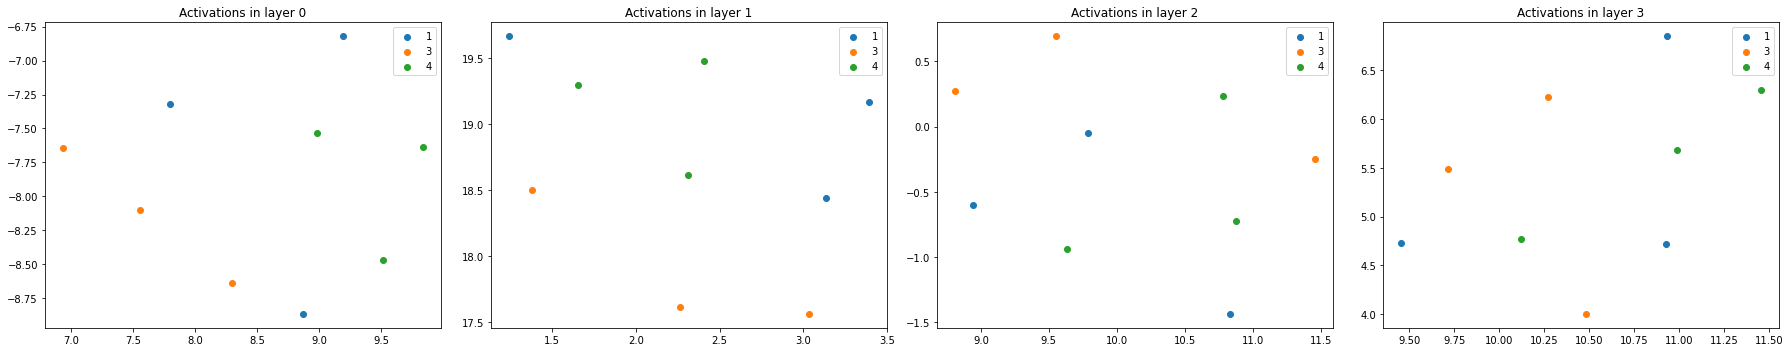

In [14]:
activations = best_untrained.activations(x)
activations_umap_plot(activations, y_np, simple_ds)

Activations in the trained network reduced to 2D using UMAP. Again, we can see that UMAP is able to cluster together similar examples in the very first layer. However, the data clusters are less separated than in the case of t-SNE.

/home/rumaak/Dropbox/College/BP_RP/neural_networks_internal_representations/venv2/lib/python3.9/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/rumaak/Dropbox/College/BP_RP/neural_networks_internal_representations/venv2/lib/python3.9/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/rumaak/Dropbox/College/BP_RP/neural_networks_internal_representations/venv2/lib/python3.9/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/rumaak/Dropbox/College/BP_RP/neural_networks_internal_representations/venv2/lib/python3.9/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


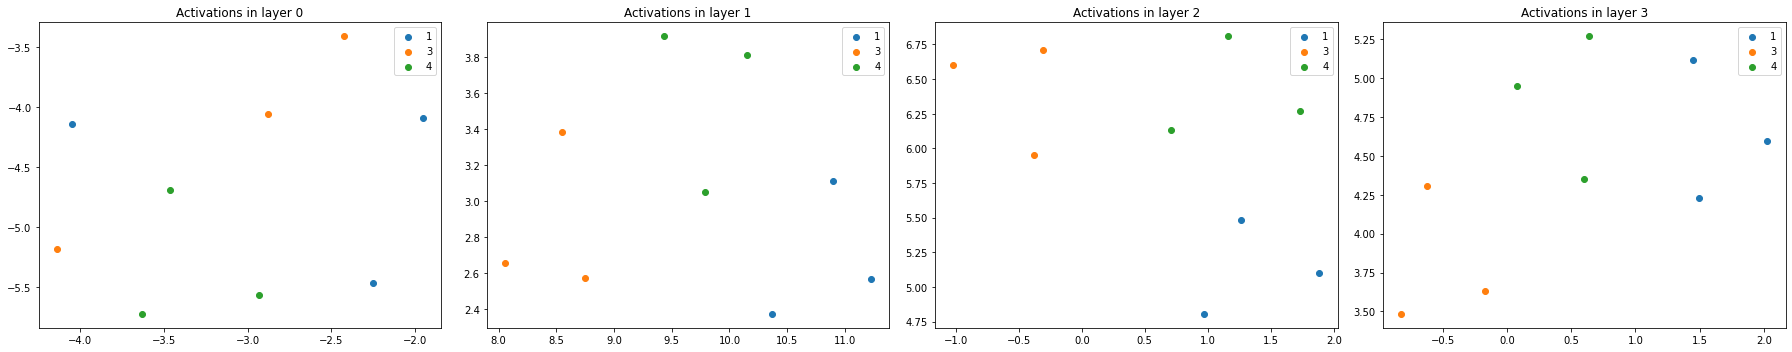

In [15]:
activations = best_network.activations(x)
activations_umap_plot(activations, y_np, simple_ds)